**1. Introducción**

El siguiente ejercicio, tiene como finalidad explorar las bondades de la plataforma Google Colaboratory para el desarrollo de algoritmos en el lenguaje de programación Python. En este cuaderno de Colab, se busca explorar módulos, funcionalidades y características de la plataforma aplicándolas al contexto de un problema o situación de la vida real.

Para ello, desarrollé el ejemplo de la recaudación del sistema de transporte público de la Ciudad Autónoma de Buenos Aires. 
En este ejemplo, se obtienen los datos del número de transacciones del sistema SUBE para colectivos, trenes, y subterráneos desde un servicio externo propio de la Ciudad de Buenos Aires. 

Con este ejemplo, se investigan módulos y funcionalidades de Colab que permitan:

*   Obtener datos desde un servicio externo por API, manejando las respuestas y formateándolas
*   Procesar los datos, obteniendo como resultado una gráfica que se pueda mostrar en el cuaderno
*   Mostrar como resultado de la ejecución, una tabla con formato que permita visualizar los datos de forma amigable al usuario
*   Descargar los datos de la tabla en formatos específicos localmente sobre la PC del usuario

Adicionalmente se hace uso (en otro conjunto de celdas de código) de los beneficios de la programación paralela, procesando un conjunto de datos similar al obtenido desde la API, para obtener la recaudación total de cada día del mes. Para ello, nos valemos de la interfaz OpenMP.


---

**2. Armado del Ambiente**

Para ejecutar el algoritmo de la celda [99], no es necesario ejecutar ningún paso previo ni instalar ningún módulo adicional.

Para la ejecución del algoritmo de procesamiento de la celda [100], previamente se debe compilar el código en C++ de la celda en cuestión. Para esto, se debe ejecutar la celda [101] y, finalmente, se podrán obtener los resultados procesados en paralelo ejecutando la celda [102]

---

**3. Desarrollo**

A continuación se codifican las funcionalidades para cumplir con el objetivo del ejercicio. El código se encuentra dividido en celdas, dentro de las cuales se desarrollan las funcionalidades correspondientes: en la primera, se investigan y demuestran diversas funcionalidades de Python para Colab; en la segunda, se codifica un programa de procesamiento en paralelo con OpenMP.

Endpoint:  https://apitransporte.buenosaires.gob.ar/datos/movilidad/transportePublico?client_id=8748fee00bec445c94b7d5e9fd83d445&client_secret=3E774efc46854c1184e16F29DeB324db
Respuesta del servidor => 200 : 'OK'


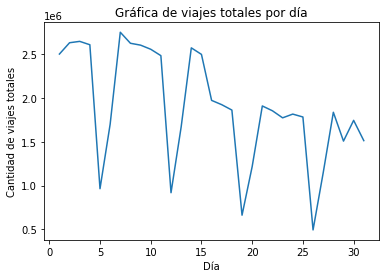

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,colectivo,tren,subte,Total
0,1897171,458373,147991,2503535
1,2015016,485034,132768,2632818
2,2020718,488773,138927,2648418
3,2011580,471399,126904,2609883
4,841912,91078,31655,964645
5,1396873,236165,68542,1701580
6,2133510,488079,131166,2752755
7,2021929,475205,129501,2626635
8,2000885,477068,127400,2605353
9,1975100,455089,128125,2558314


In [ ]:
import requests 
import numpy as np
import json
import pandas as pan
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datetime import date
from google.colab import files

# Defino el Endpoint de la API del servicio de tránsito
url = ('https://apitransporte.buenosaires.gob.ar/datos/movilidad/transportePublico?client_id=8748fee00bec445c94b7d5e9fd83d445&client_secret=3E774efc46854c1184e16F29DeB324db'
       )

print("Endpoint: ", url)

# GET request al endpoint previamente definido
response = requests.get(url)

# Muestro el código de la respuesta
print(f"Respuesta del servidor => {response.status_code} : '{response.reason}'")

# Parseo a JSON la respuesta obtenida
payload = response.json()

totales = []

datos_viajes = {
    'colectivo': [],
    'tren': [],
    'subte': []
}

# Remuevo los primeros elementos ya que traen datos parcializados
payload.pop(0);
payload.pop(0);

# Recorro el objeto de tipo JSON previamente obtenido, asignando a cada lista de datos_viajes los valores correspondientes
for registro in payload:
  if registro['tipo_transporte'] == 'Colectivo':
    datos_viajes['colectivo'].append(int(registro['cantidad']))
  elif registro['tipo_transporte'] == 'Tren':
    datos_viajes['tren'].append(int(registro['cantidad']))
  else:
    datos_viajes['subte'].append(int(registro['cantidad']))

# Transformo el objeto en un DataFrame
df = pan.DataFrame(datos_viajes)

# Efectúo la suma total de viajes realizados día por día y lo asigno a una nueva columna del dataframe
df["Total"] = df.sum(axis=1)

# Itero sobre el DataFrame, agregando los totales a una lista
for index, row in df.iterrows():
  totales.append((index+1,row['Total']))

# Defino los valores X e Y que luego serán graficados, correspondientes a Día - Total de viajes
x_val = [x[0] for x in totales]
y_val = [x[1] for x in totales]

# Grafico los datos procesados
plt.plot(x_val,y_val)
plt.title('Gráfica de viajes totales por día')
plt.xlabel('Día')
plt.ylabel('Cantidad de viajes totales')
plt.show()

# Preparo el reporte de viajes diarios en formato CSV
df.to_csv(r'Reporte_viajes.csv', index = False, header=True)

# Se descarga el archivo en la PC del usuario
files.download('Reporte_viajes.csv') 

# Muestro el DataFrame sobre el cuaderno
df

In [ ]:
procesamiento_paralelo = """
  #include <iostream>
  #include <omp.h>
  #define MEDIOS_TRANSPORTE 3

  using namespace std;

  int main(int arg_qty, char* argv[]) 
  { 
    
    if(arg_qty != 5)
    {
        std::cerr<< " Error en los parametros. Se deben ingresar 5 parámetros para iniciar la ejecucion."<<std::endl;
        exit(-1);
    }

    int cantidad_dias = atoi(argv[1]);
    float precio_colectivo = atof(argv[2]);
    float precio_tren = atof(argv[3]);
    float precio_subte = atof(argv[4]);

    int matriz_viajes[cantidad_dias][MEDIOS_TRANSPORTE];
    float res[cantidad_dias];
    float tarifas[MEDIOS_TRANSPORTE] = {precio_colectivo, precio_tren, precio_subte};

    for(int i = 0; i<cantidad_dias; i++){
      for(int j=0; j<MEDIOS_TRANSPORTE; j++){
        matriz_viajes[i][j] = (rand() % 100);
      }
    }

    std::cout<<"MATRIZ DE CANTIDAD DE VIAJES POR DIA POR TIPO DE TRANSPORTE"<<endl;
    for(int w = 0; w<cantidad_dias; w++){
      for(int q=0; q<MEDIOS_TRANSPORTE; q++){
        std::cout<<matriz_viajes[w][q]<<" ";
      }
      std::cout<<endl;
    }

    std::cout<<"TARIFAS POR MEDIO DE TRANSPORTE"<<endl;
    for(int t = 0; t<MEDIOS_TRANSPORTE; t++){
      std::cout<<tarifas[t]<<" ";
    }

    std::cout<<endl;

    float sum;
    #pragma omp parallel for
    for(int i=0;i<cantidad_dias;i++){
      sum=0;
      for(int j=0; j<MEDIOS_TRANSPORTE; j++){
        //std::cout<<"El hilo " << omp_get_thread_num()<< " se encuentra procesando la fila "<< i <<std::endl; 
        sum+=(matriz_viajes[i][j]*tarifas[j]);
      }
      res[i]=sum;
    }

    std::cout<<"MATRIZ RESULTANTE (Recaudación diaria total)"<<endl;
    for(int a = 0; a<cantidad_dias; a++){
        std::cout<<res[a]<<std::endl;
    }
  }
      
"""
archivo = open("mult.cpp", "w")
archivo.write(procesamiento_paralelo)
archivo.close()

In [ ]:
!g++ -o recaudacion_diaria -fopenmp mult.cpp

In [ ]:
%env OMP_NUM_THREADS=6
!./recaudacion_diaria 6 18.5 100 14

env: OMP_NUM_THREADS=6
MATRIZ DE CANTIDAD DE VIAJES POR DIA POR TIPO DE TRANSPORTE
83 86 77 
15 93 35 
86 92 49 
21 62 27 
90 59 63 
26 40 26 
TARIFAS POR MEDIO DE TRANSPORTE
18.5 100 14 
MATRIZ RESULTANTE (Recaudación diaria total)
11213.5
10067.5
11477
6966.5
8447
4845


**4.1 Tabla de Pasos**

Resumen de las funciones principales del desarrollo de la celda número 1 del cuaderno

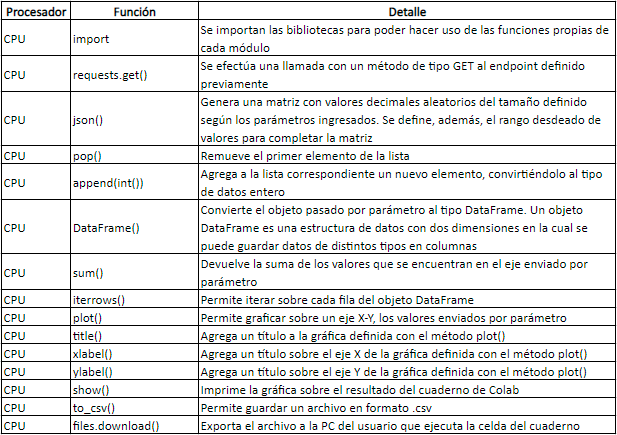

---

**4.2 Tabla de Pasos**

Resumen de las funciones principales del desarrollo de la celda 2, sobre la cual se desarrolla el código para efectuar procesamiento en paralelo a trvés de OpenMP

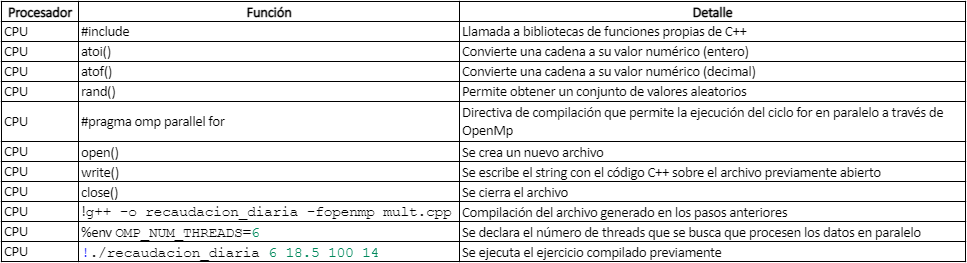

---

**5. Conclusiones**

*Repaso*

Como vimos a lo largo de este ejercicio, la plataforma Google Colab constituye una herramienta práctica, potente y efectiva para el desarrollo en el lenguaje de programación Python. Brinda las herramientas necesarias para programar en dicho lenguaje, y permite acceder e importar todos los módulos y bibliotecas propias de Python. Es por esto que se pueden ejecutar funcionalidades que permiten formatear la salida de datos, provee el acceso a APIs, e incluso permite la integración de los cuadernos con GitHub.

Adicionalmente, valiéndonos de Python como lenguaje intermediario, Colab nos permite compilar y ejecutar fragmentos de código escritos en otros lenguajes de programación, tal como C++ como vimos en este cuaderno. Así, podremos llevar a cabo procedimientos de procesamiento en paralelo dentro de la misma plataforma. En nuestro caso, utilizamos OpenMP, pero también se destacan para su uso las interfaces MPI y OpenGL que se pueden implementar en los cuadernos de Colab.

Como desventaja de la herramienta, podemos enunciar que solamente se puede trabajar si se dispone de conexión a internet.


*Lecciones Aprendidas*

En el desarrollo de este ejercicio, obtuve un conocimiento más profundo de los cuadernos de Colab, pude investigar funcionalidades adicionales que no había tenido en cuenta en ejercicios anteriores, investigué cómo se pueden implementar en cada cuaderno, y utilicé bibliotecas y módulos que proveen acceso a funcionalidades que van más allá de la programación en sí misma, agregando formatos a las respuestas en la ejecución de una celda, por ejemplo.

Además, el ejercicio me permitió comprender de qué forma se pueden adoptar soluciones de procesamiento paralelo sin ser necesaria la ejecución sobre GPU, haciendo uso de la interfaz OpenMP.

*Sugerencias para continuar con el ejercicio, mejoras*

Como mejora para adoptar, propondría investigar de qué forma se puede enviar por parámetros de ejecución una matriz al código que ejecuta OpenMP. De este modo, se podrían integrar ambas celdas, desarrollando una solución integral que permita, no solo visualizar los datos fehacientes obtenidos desde la API de transporte de la Ciudad Autónoma de Buenos Aires en gráficos/tablas, sino que además se podría obtener la recaudación real en cada uno de los días que se muestran en la tabla de tipo DataFrame.

---

**6. Bibliografía**

[1] Cómputo en paralelo con OpenMP: [PDF](http://personal.cimat.mx:8181/~miguelvargas/Course%20notes/Computo%20en%20paralelo%20con%20OpenMP%201.pdf)

[2] OpenMP: [PDF](http://ocw.uc3m.es/ingenieria-informatica/arquitectura-de-computadores-ii/otros-recursos-1/or-f-008.-curso-de-openmp)

[3] API Tutorial - Google Colab: [Cuaderno de Colab](https://colab.research.google.com/github/nestauk/im-tutorials/blob/3-ysi-tutorial/notebooks/APIs/API_tutorial.ipynb#scrollTo=EnmZWY7VYQi0)

[4] Pandas: [WEB](https://pandas.pydata.org/)

[5] Pyplot tutorial: [WEB](https://matplotlib.org/tutorials/introductory/pyplot.html)

[6] How to download files from Google Colab: [WEB](https://www.honchosearch.com/blog/seo/how-to-download-files-from-google-colab/)

[7] Python Pandas: Iniciando Con DataFrames: [WEB](https://likegeeks.com/es/tutorial-de-python-pandas/)

[8] Mastering the features of Google Colaboratory: [WEB](https://towardsdatascience.com/mastering-the-features-of-google-colaboratory-92850e75701)

http://personal.cimat.mx:8181/~miguelvargas/Course%20notes/Computo%20en%20paralelo%20con%20OpenMP%201.pdf

pal general
https://towardsdatascience.com/mastering-the-features-of-google-colaboratory-92850e75701